<a href="https://colab.research.google.com/github/Ackerman-97/Algorithmes-avanc-s/blob/main/R%C3%A9solutionTSPparACO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import random

class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        self.matrix = cost_matrix
        self.rank = rank
        self.pheromone = [[1 / (rank * rank) for j in range(rank)] for i in range(rank)]


class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int, strategy: int):
        #param alpha: coefficient d’importance des phéromones
        #param beta: coefficient d’importance de la visibilité
        #param rho: coefficient d’évaporation des phéromones
        #param q: quantité de phéromones disponibles pour chaque fourmis
        #param strategy: e taux de phéromones sur l’arc i, j à l’instant t. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]

    def solve(self, graph: Graph):
        best_cost = float('inf')
        best_solution = []
        for gen in range(self.generations):
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                for i in range(graph.rank - 1):
                    ant._select_next()
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
               
                ant._update_pheromone_delta()
            self._update_pheromone(graph, ants)
        return best_solution, best_cost


class _Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []  # tabu list
        self.pheromone_delta = []  #  la quantité de phéromone déposée par les fourmis dans  intervalle de temps sur l’arc (i, j).
        self.allowed = [i for i in range(graph.rank)]  # nœuds autorisés pour la sélection suivante
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in range(graph.rank)]  
        start = random.randint(0, graph.rank - 1)  # démarrer à partir de n'importe quel nœud
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][i] ** self.colony.beta
        probabilities = [0 for i in range(self.graph.rank)]  # probabilités de passer à un nœud à l'étape suivante
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)  #tester si la liste autorisée contient i
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass  # ne rien faire
        # sélectionner le nœud suivant par probabilité
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    def _update_pheromone_delta(self):
        self.pheromone_delta = [[0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        for _ in range(1, len(self.tabu)):
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            if self.colony.update_strategy == 1:  # ant-quality system
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:  # ant-density system
                self.pheromone_delta[i][j] = self.colony.Q / self.graph.matrix[i][j]
            else:  # ant-cycle system
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

In [9]:
import operator
import matplotlib.pyplot as plt


def plot(points, path: list):
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])
    

    y = list(map(operator.sub, [max(y) for i in range(len(points))], y))
    plt.plot(x, y, 'co')

    for _ in range(1, len(path)):
        i = path[_ - 1]
        j = path[_]
        plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='r', length_includes_head=True)


    plt.xlim(0, max(x) * 1.1)
    plt.ylim(0, max(y) * 1.1)
    plt.show()

[[ 1 26 14 72 70 10  5 19]
 [12 63 80 57 73 15 40 54]
 [77 84 53 18 76 16 54 84]
 [18 18 19 39 21 47 72 79]
 [56 43 83 45  5 10 72 95]
 [12 96  5 71 20 49 17 42]
 [ 4 44 48 46 98 66 28 30]
 [18  2 82 32 88 50 22 89]]
cost: 152.0, path: [0, 6, 7, 1, 5, 2, 3, 4]


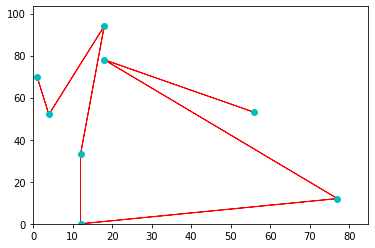

In [10]:
import math
import networkx as nx
import numpy as np

def create_distance_matrix(n):
    a = np.random.randint(1, high=100, size=(n, n))
    print(a)
    return a

def create_graph(matrix, n):
    G = nx.Graph()
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            G.add_edge(i, j)
            G[i][j]['weight'] = matrix[i][j]
    nx.draw(G, with_labels=True)
    plt.clf()

def distance(city1: dict, city2: dict):
    return math.sqrt((city1['x'] - city2['x']) ** 2 + (city1['y'] - city2['y']) ** 2)


def main():
    i = 8
    n = 8
    matrix = create_distance_matrix(i)
    create_graph(matrix,i)
    aco = ACO(10, 100, 1.0, 10.0, 0.5, 10, 2)
    graph = Graph(matrix, n)
    path, cost = aco.solve(graph)
    print('cost: {}, path: {}'.format(cost, path))
    plot( matrix,path)

if __name__ == '__main__':
    main()